# simple 6D PS reconstruction

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan_2screens
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data_2screens
from phase_space_reconstruction.train import train_3d_scan_2screens

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

from stats import plot_projections_with_contours

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
yaml_dir = os.path.join('data', 'yaml_files')
save_dir =  os.path.join('data', 'two_screens')
p0c = 43.36e6 # reference momentum in eV/c
gt = create_beam(
    base_yaml = os.path.join(yaml_dir, 'base.yaml'),
    transforms_yaml = os.path.join(yaml_dir, 'transforms-nonlinear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
)

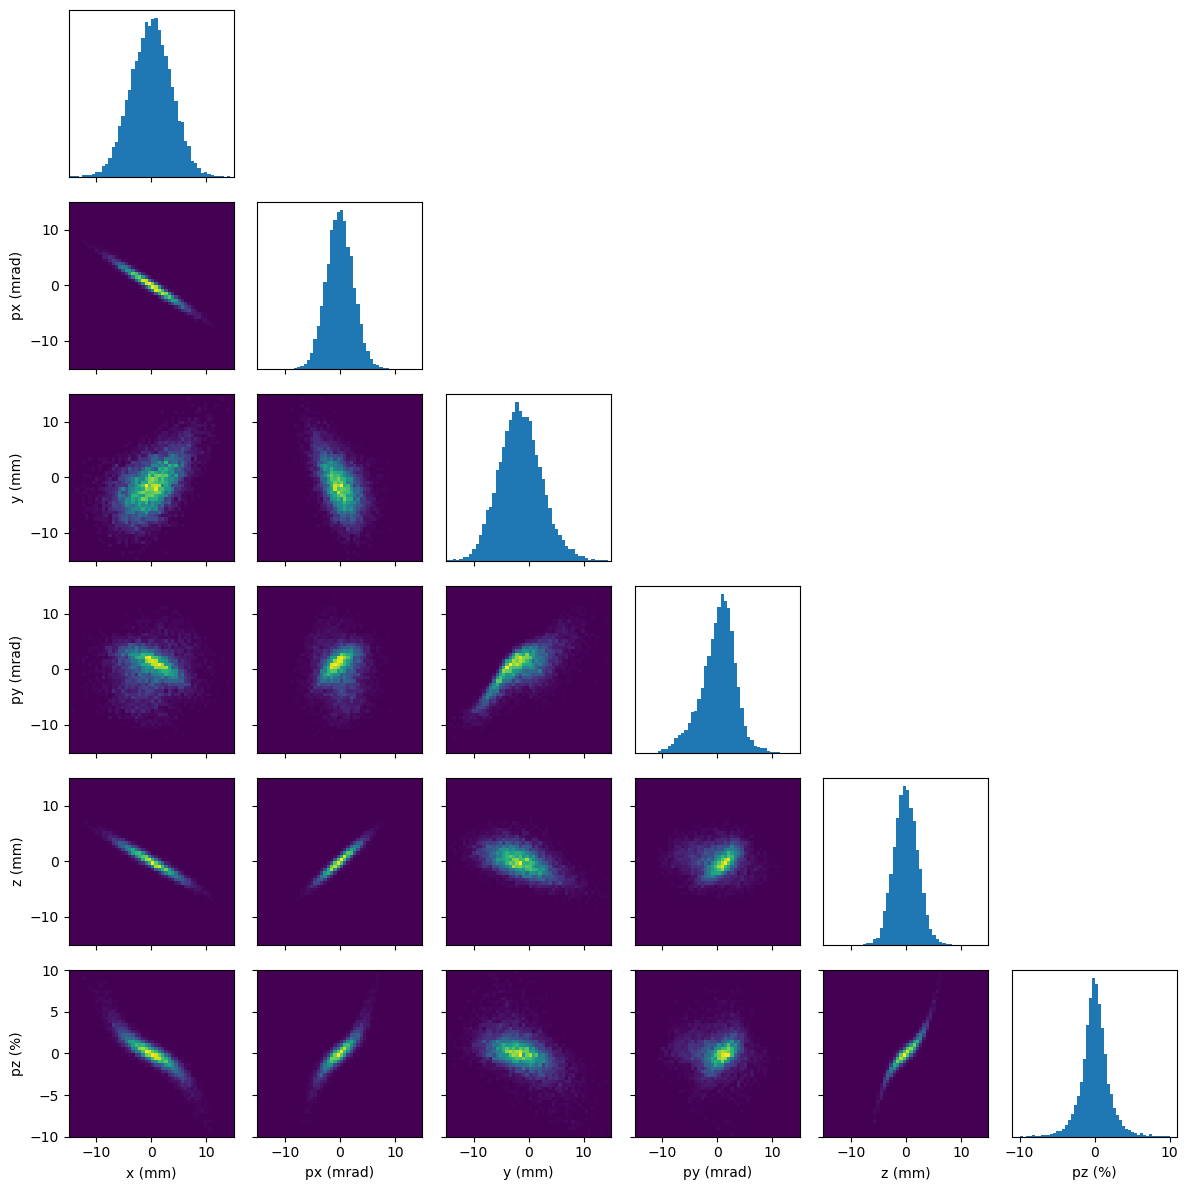

In [3]:
#plot gt beam
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-10e-2, 10e-2]]) 
fig, ax = plot_projections(
    gt.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 = 7.570125
k2 = -15.704693
k3 = 1.0

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on

# create 2 diagnostic screens: 
def create_screen(size, pixels):
    bins = torch.linspace(-size/2, size/2, pixels)
    bandwidth = (bins[1]-bins[0]) / 2
    return ImageDiagnostic(bins, bins, bandwidth)

screen0 = create_screen(100*1e-3, 200)
screen1 = create_screen(200*1e-3, 200)

## 3D scan training data

In [6]:
# generate and save train and test datasets
train_dset = run_3d_scan_2screens(
    gt, 
    lattice,
    screen0,
    screen1, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(save_dir, '3d_scan_train.dset'),
    n_imgs_per_param = 4,
)

print(train_dset.params.shape)
print(train_dset.images.shape)

dataset0 saved as 'data/two_screens/3d_scan_train.dset'
torch.Size([5, 2, 2, 3])
torch.Size([5, 2, 2, 4, 200, 200])


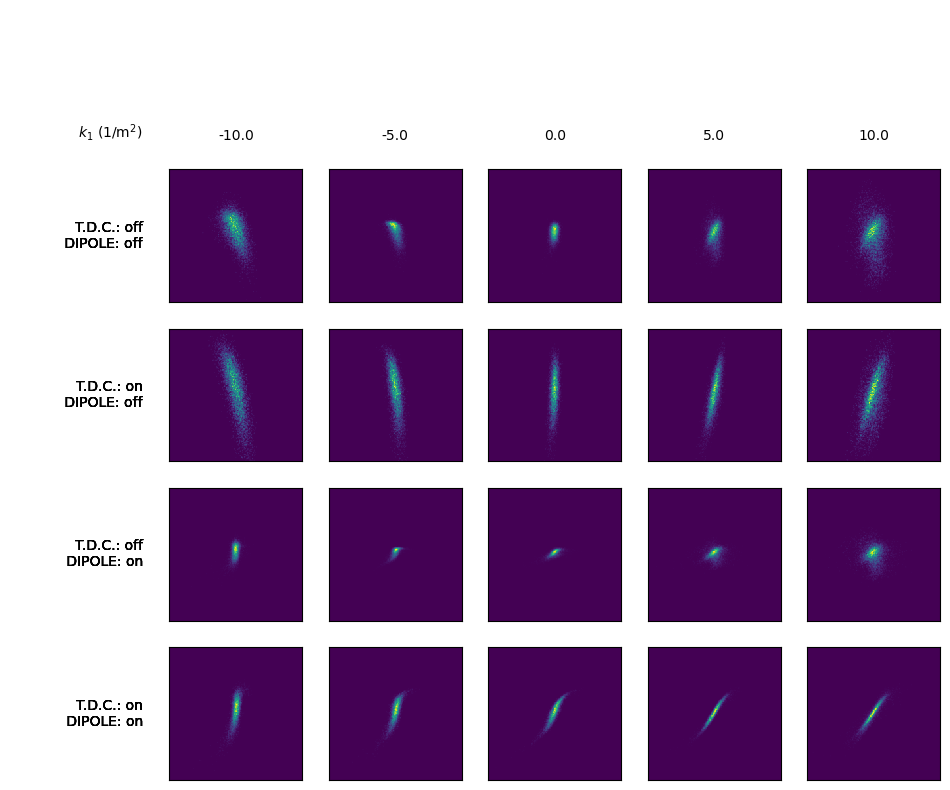

In [7]:
plot_3d_scan_data_2screens(train_dset)
plt.show()

### 10,000 particles

In [8]:
%%time

# training
pred_beam = train_3d_scan_2screens(
    train_dset, 
    lattice, 
    p0c, 
    screen0,
    screen1,
    ids = scan_ids,
    n_epochs = 1_000, 
    n_particles = 10_000, 
    device = 'cuda'
    )
pred_beam = pred_beam.numpy_particles()
torch.cuda.empty_cache()

Using device: cuda


/home/jp/mambaforge/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4763147., device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(770695.4375, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(738440.6875, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(670319.4375, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(664400.1250, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(666123.8750, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(642108.9375, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(637762.6875, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(655713.3750, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(644747.8125, device='cuda:0', grad_fn=<MulBackward0>)
CPU times: user 1min 30s, sys: 4.61 s, total: 1min 35s
Wall time: 1min 35s


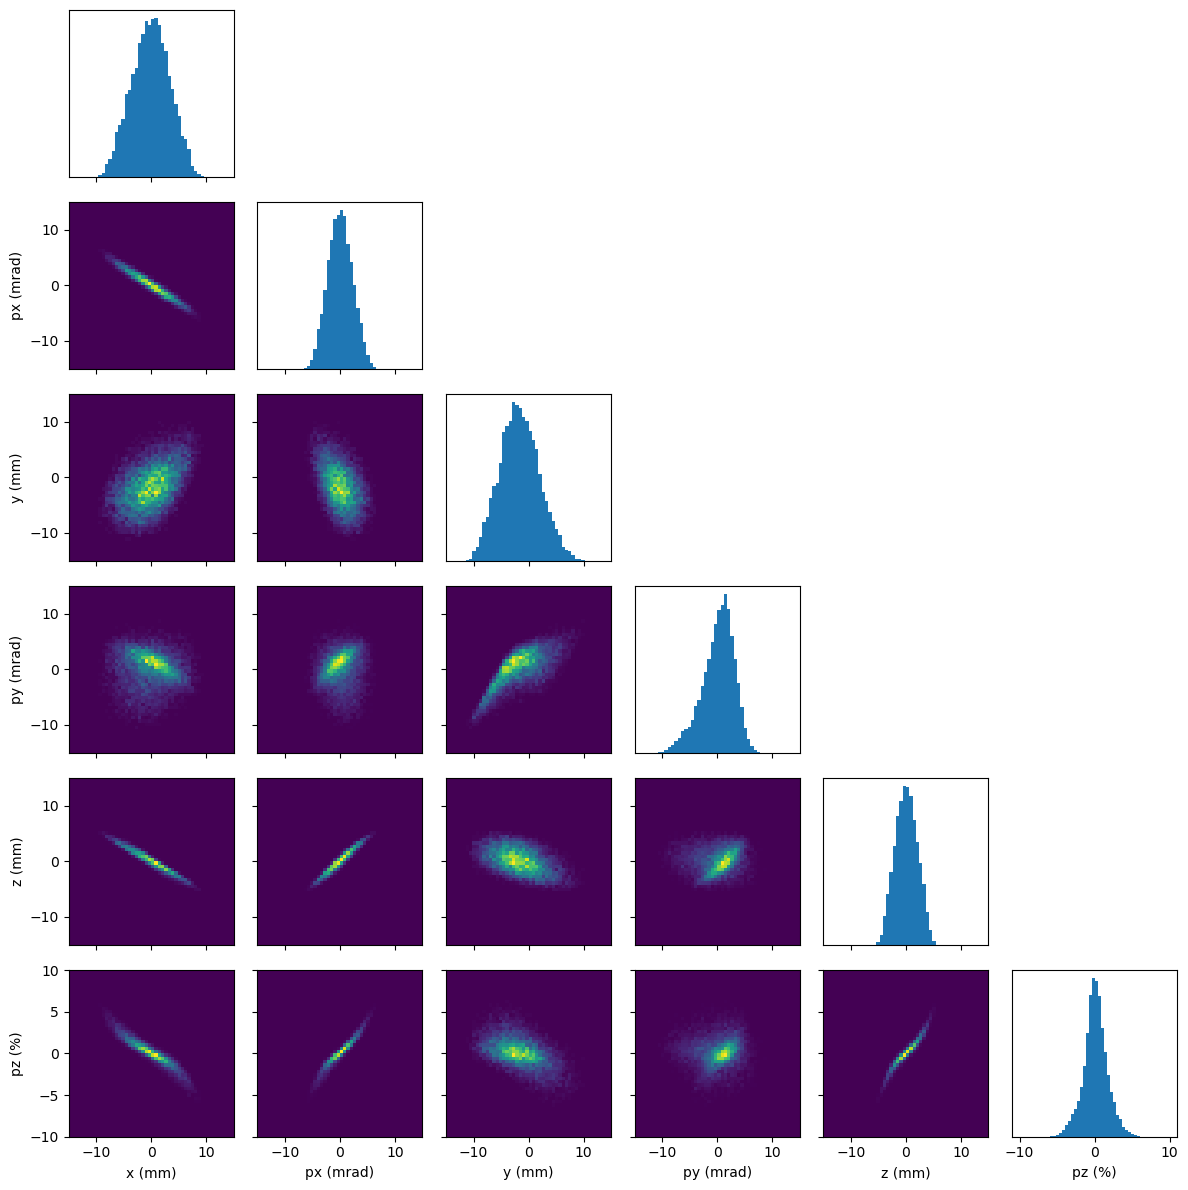

In [10]:
# reconstructed beam projections:
fig, ax = plot_projections(pred_beam,
                           custom_lims = lims,
                           bins = 50
                           )
plt.show()

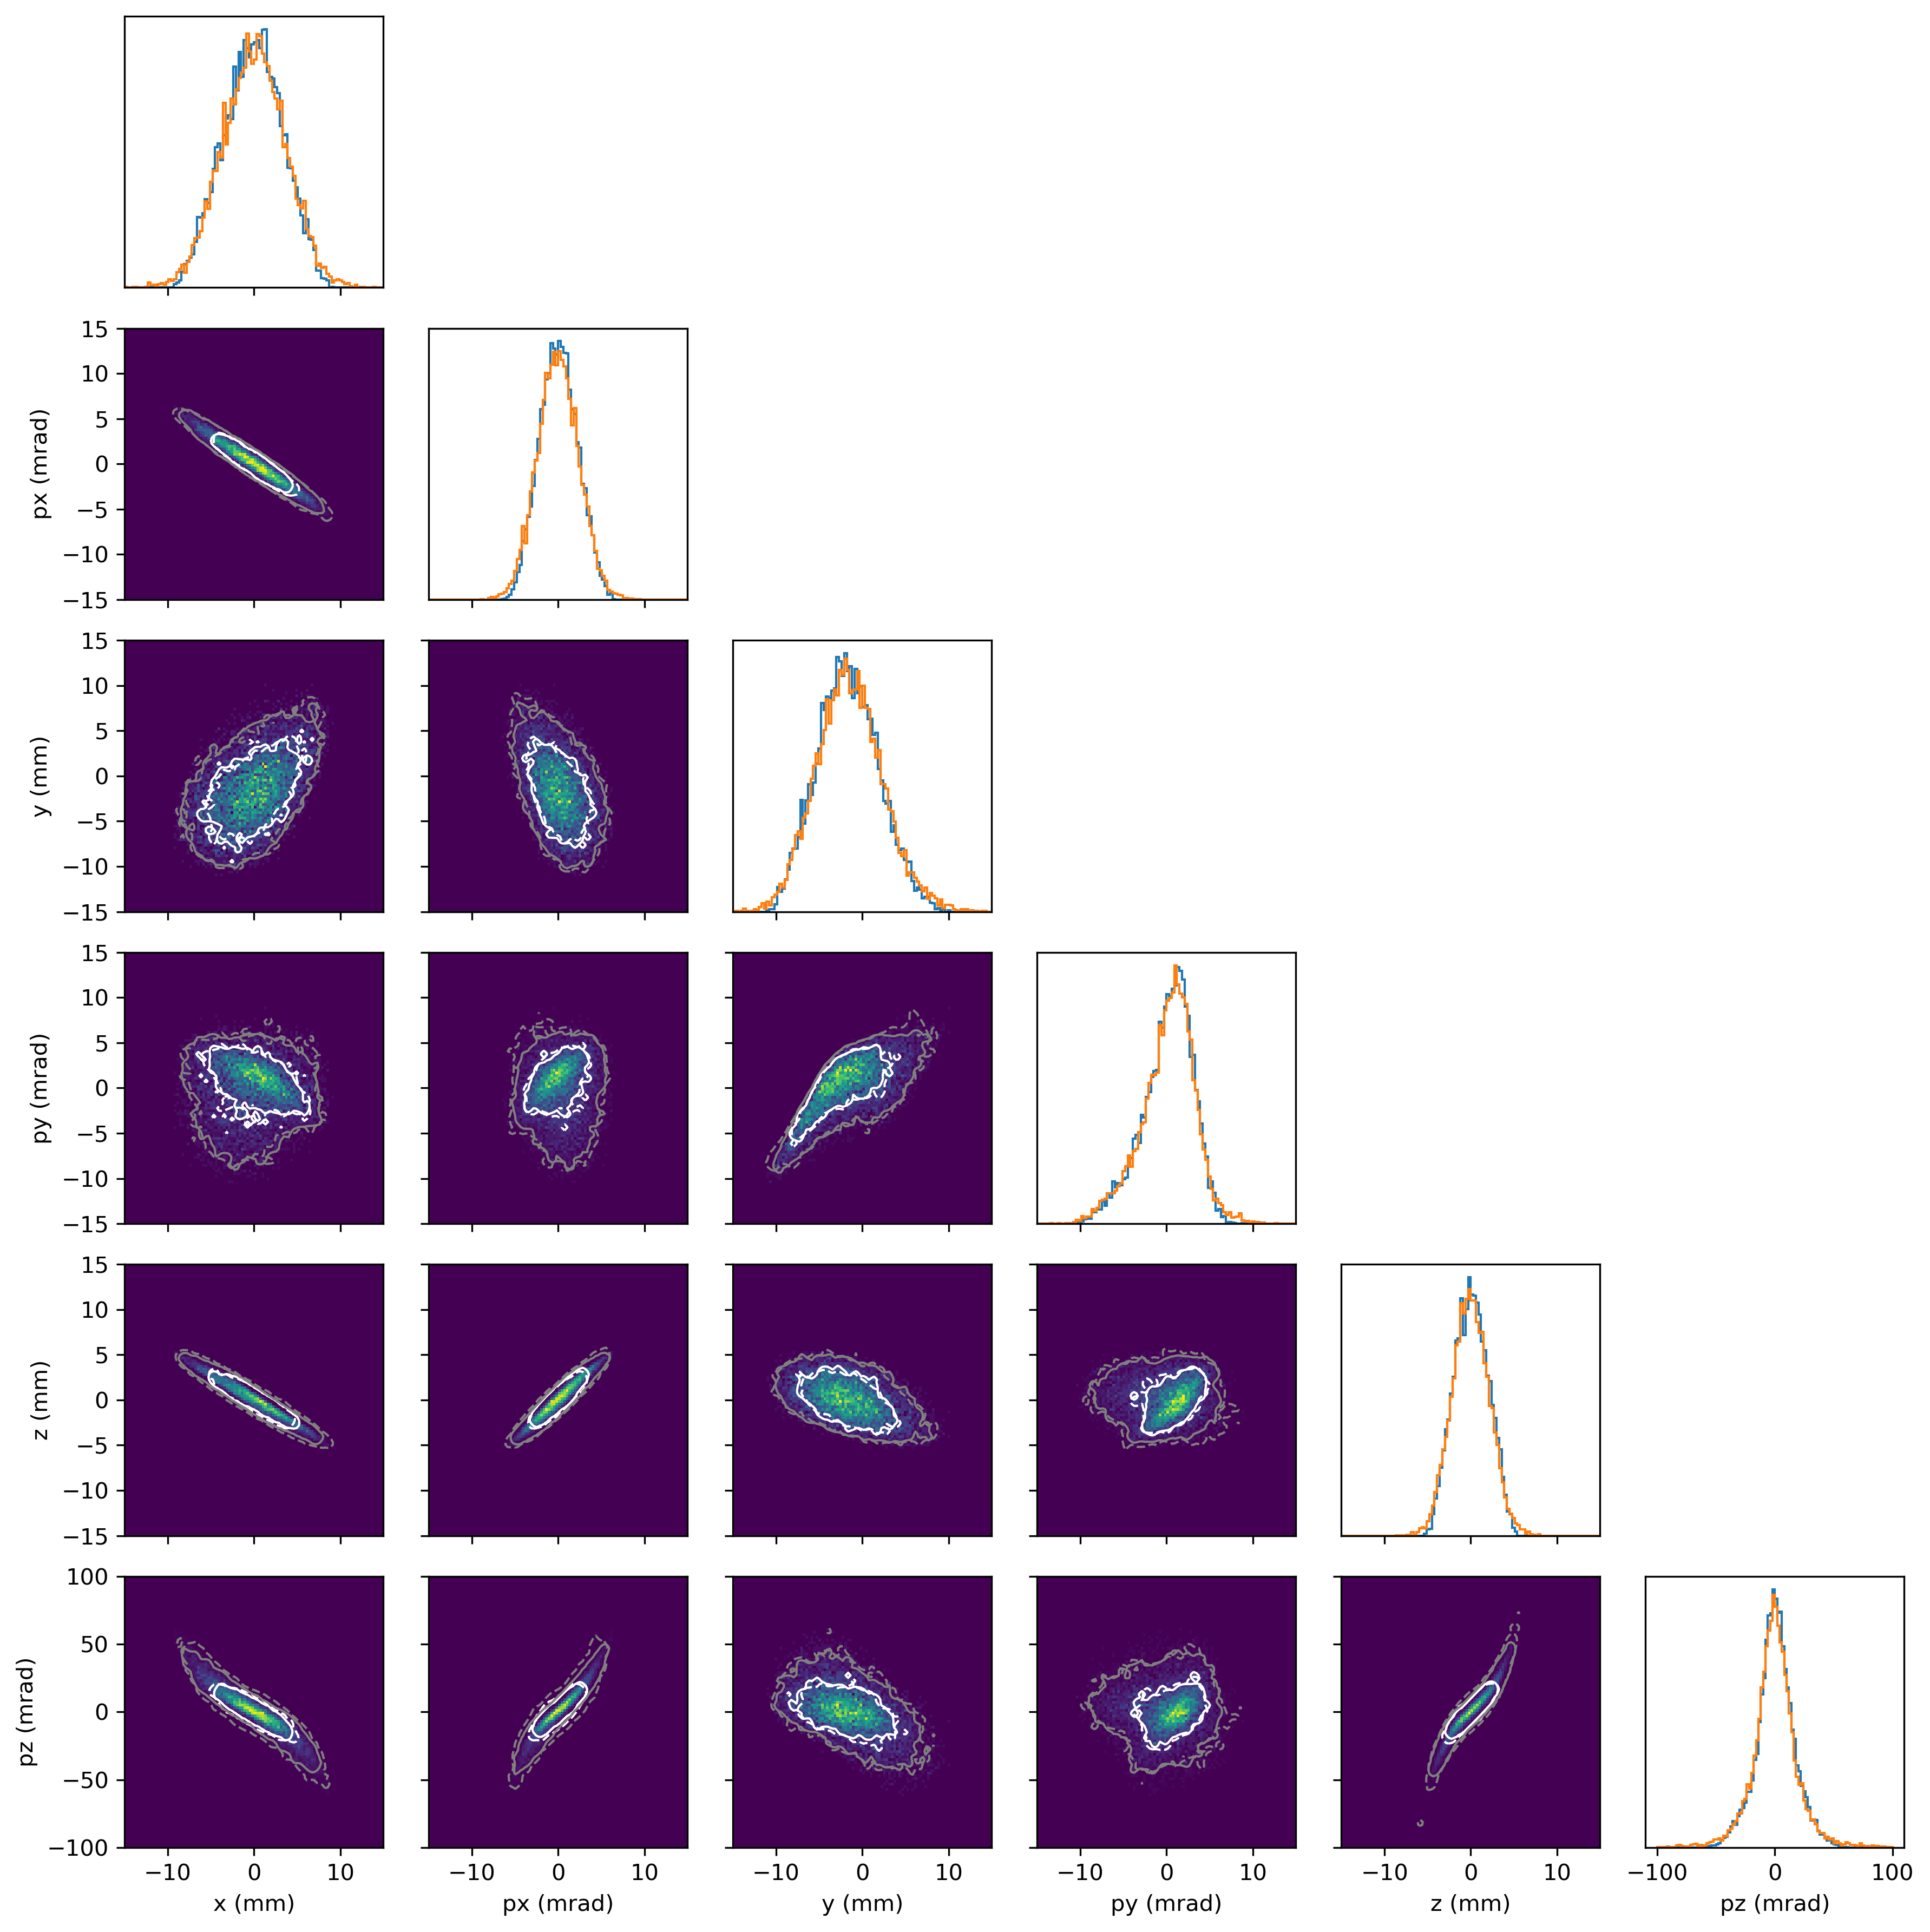

In [22]:
plot_projections_with_contours(pred_beam, gt, custom_lims=lims, bins=100)
plt.show()